# Build Language Detection Models

Download: https://downloads.tatoeba.org/exports/

In [5]:
import matplotlib.pyplot as plt
from numpy import ndarray, argmax
import pandas as pd
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder

In [6]:
LANGUAGES: list[str] = ["deu", "eng", "fra", "ita", "por", "spa"]

## Load Data

In [7]:
data: pd.DataFrame = pd.read_csv(
    "./sentences.csv", sep="\t", encoding="utf8", index_col=0, names=["lang", "text"]
)
data

,lang,text
1,cmn,我們試試看！
2,cmn,我该去睡觉了。
3,cmn,你在干什麼啊？
4,cmn,這是什麼啊？
5,cmn,今天是６月１８号，也是Muiriel的生日！
...,...,...
11931349,fra,"C'est un sale boulot, mais il faut bien que qu..."
11931350,eng,Are you an investor?
11931351,eng,"Sorry, I've dialed the wrong number."
11931352,eng,I think I've dialed the wrong number.


## Filter by text length

In [8]:
len_cond: list[bool] = [True if 20 <= len(s) <= 200 else False for s in data["text"]]
data: pd.DataFrame = data[len_cond]
data

,lang,text
5,cmn,今天是６月１８号，也是Muiriel的生日！
21,cmn,选择什么是“对”或“错”是一项艰难的任务，我们却必须要完成它。
67,cmn,我们看东西不是看其实质，而是以我们的主观意识看它们的。
71,cmn,生活就是當你忙著進行你的計劃時總有其他的事情發生。
77,deu,Lass uns etwas versuchen!
...,...,...
11931349,fra,"C'est un sale boulot, mais il faut bien que qu..."
11931350,eng,Are you an investor?
11931351,eng,"Sorry, I've dialed the wrong number."
11931352,eng,I think I've dialed the wrong number.


## Filter by text language

In [9]:
data: pd.DataFrame = data[data["lang"].isin(LANGUAGES)]
data

,lang,text
77,deu,Lass uns etwas versuchen!
78,deu,Ich muss schlafen gehen.
81,deu,Heute ist der 18. Juni und das ist der Geburts...
82,deu,"Herzlichen Glückwunsch zum Geburtstag, Muiriel!"
83,deu,Muiriel ist jetzt 20.
...,...,...
11931349,fra,"C'est un sale boulot, mais il faut bien que qu..."
11931350,eng,Are you an investor?
11931351,eng,"Sorry, I've dialed the wrong number."
11931352,eng,I think I've dialed the wrong number.


## Select 50000 rows for each language

In [10]:
data_trim: pd.DataFrame = pd.DataFrame(columns=["lang", "text"])

for language in LANGUAGES:
    lang_trim: pd.DataFrame = data[data["lang"] == language].sample(
        50000, random_state=100
    )
    data_trim = pd.concat([data_trim, lang_trim], ignore_index=True)

data_trim

,lang,text
0,deu,Normalerweise geht Tom zu Fuß zur Schule.
1,deu,Das sehe ich und das verstehe ich.
2,deu,Phantasie erzeugt keinen Wahnsinn... Dichter w...
3,deu,Eines Tages werden wir alle sterben müssen.
4,deu,Das Wesentliche an jeder Erfindung tut der Zuf...
...,...,...
299995,spa,Ella está tratando de ahorrar todo lo posible.
299996,spa,"Hoy hace calor, así que puedes nadar en el mar."
299997,spa,Mary cuida mucho su aspecto.
299998,spa,Tengo que preparar varias clases para mañana.


## Create a random train, valid, test split

In [11]:
data_shuffle: pd.DataFrame = data_trim.sample(frac=1)

train: pd.DataFrame = data_shuffle[0:210000]
valid: pd.DataFrame = data_shuffle[210000:270000]
test: pd.DataFrame = data_shuffle[270000:300000]

## Get Trigrams

In [12]:
def get_trigrams(corpus, n_feat=200):
    """
    Returns a list of the N most common character trigrams from a list of sentences
    params
    ------------
        corpus: list of strings
        n_feat: integer
    """

    # fit the n-gram model
    vectorizer: CountVectorizer = CountVectorizer(
        analyzer="char", ngram_range=(3, 3), max_features=n_feat
    )

    vectorizer.fit_transform(corpus)

    # Get model feature names
    feature_names = vectorizer.get_feature_names_out()

    return feature_names

## Obtain trigrams from each language

In [13]:
features = {}
features_set = set()

for language in LANGUAGES:
    # get corpus filtered by language
    corpus = train[train["lang"] == language]["text"]
    # get 200 most frequent trigrams
    trigrams = get_trigrams(corpus)
    # add to dict and set
    features[language] = trigrams
    features_set.update(trigrams)

features_set

{' a ',
 ' ac',
 ' al',
 ' an',
 ' ar',
 ' as',
 ' at',
 ' au',
 ' av',
 ' be',
 ' bi',
 ' bo',
 ' ca',
 ' ce',
 ' ch',
 ' co',
 ' cu',
 " d'",
 ' da',
 ' de',
 ' di',
 ' do',
 ' du',
 ' dé',
 ' e ',
 ' ei',
 ' el',
 ' em',
 ' en',
 ' er',
 ' es',
 ' et',
 ' fa',
 ' fi',
 ' fo',
 ' fr',
 ' ge',
 ' go',
 ' ha',
 ' he',
 ' hi',
 ' ho',
 ' i ',
 ' ic',
 ' ih',
 ' il',
 ' in',
 ' is',
 ' it',
 ' je',
 ' ka',
 ' kn',
 " l'",
 ' la',
 ' le',
 ' li',
 ' lo',
 ' ma',
 ' me',
 ' mi',
 ' mo',
 ' mu',
 ' má',
 " n'",
 ' na',
 ' ne',
 ' ni',
 ' no',
 ' nã',
 ' o ',
 ' of',
 ' on',
 ' pa',
 ' pe',
 ' pi',
 ' pl',
 ' po',
 ' pr',
 ' pu',
 ' qu',
 ' re',
 ' ri',
 ' sa',
 ' sc',
 ' se',
 ' sh',
 ' si',
 ' so',
 ' st',
 ' su',
 ' ta',
 ' te',
 ' th',
 ' ti',
 ' to',
 ' tr',
 ' tu',
 ' um',
 ' un',
 ' va',
 ' ve',
 ' vi',
 ' vo',
 ' wa',
 ' we',
 ' wh',
 ' wi',
 ' wo',
 ' y ',
 ' yo',
 ' zu',
 ' à ',
 ' è ',
 ' é ',
 ' ét',
 "'ai",
 "'es",
 "'s ",
 "'t ",
 ', d',
 ', w',
 'a a',
 'a c',
 'a d',
 'a e',


## Create vocabulary list using feature set

In [14]:
vocab = dict()
for index, feature in enumerate(features_set):
    vocab[feature] = index
vocab

{'man': 0,
 'to ': 1,
 'a e': 2,
 'con': 3,
 'ada': 4,
 'en ': 5,
 'ti ': 6,
 'ora': 7,
 'nge': 8,
 'pia': 9,
 'ele': 10,
 'n a': 11,
 'us ': 12,
 "'es": 13,
 'ón ': 14,
 'ine': 15,
 'ste': 16,
 'not': 17,
 'was': 18,
 'ain': 19,
 'ir ': 20,
 'ben': 21,
 'at.': 22,
 ' il': 23,
 'a t': 24,
 'mos': 25,
 'e w': 26,
 'nn ': 27,
 'res': 28,
 'be ': 29,
 ' al': 30,
 ' me': 31,
 'om ': 32,
 'a n': 33,
 'we ': 34,
 'nda': 35,
 ' ne': 36,
 'out': 37,
 'sso': 38,
 ' er': 39,
 'ion': 40,
 'you': 41,
 'o m': 42,
 ' ti': 43,
 'ría': 44,
 'des': 45,
 'omm': 46,
 'r w': 47,
 'rie': 48,
 'auf': 49,
 'de ': 50,
 'a s': 51,
 'ma ': 52,
 'dad': 53,
 'die': 54,
 'm c': 55,
 'ica': 56,
 ' ar': 57,
 't p': 58,
 ' bo': 59,
 'en.': 60,
 'ern': 61,
 'cha': 62,
 'dan': 63,
 'e v': 64,
 'un ': 65,
 'sie': 66,
 'e t': 67,
 'dos': 68,
 't w': 69,
 ' en': 70,
 'ans': 71,
 ' co': 72,
 'au ': 73,
 ' o ': 74,
 'und': 75,
 ' ce': 76,
 'ce ': 77,
 'n, ': 78,
 'n v': 79,
 ' je': 80,
 ' le': 81,
 'ted': 82,
 'nne': 83,
 '

## Train count vectoriser using vocabulary

In [15]:
vectorizer = CountVectorizer(analyzer="char", ngram_range=(3, 3), vocabulary=vocab)
vectorizer

CountVectorizer(analyzer='char', ngram_range=(3, 3),
                vocabulary={' a ': 91, ' ac': 151, ' al': 30, ' an': 233,
                            ' ar': 57, ' as': 490, ' at': 258, ' au': 337,
                            ' av': 197, ' be': 557, ' bi': 299, ' bo': 59,
                            ' ca': 85, ' ce': 76, ' ch': 500, ' co': 72,
                            ' cu': 363, " d'": 118, ' da': 438, ' de': 128,
                            ' di': 340, ' do': 404, ' du': 241, ' dé': 520,
                            ' e ': 388, ' ei': 263, ' el': 115, ' em': 451,
                            ' en': 70, ' er': 39, ...})

## Create feature matrix for training set

In [16]:
corpus = train["text"]
x = vectorizer.fit_transform(corpus)
feature_names = vectorizer.get_feature_names_out()
feature_names

array(['man', 'to ', 'a e', 'con', 'ada', 'en ', 'ti ', 'ora', 'nge',
       'pia', 'ele', 'n a', 'us ', "'es", 'ón ', 'ine', 'ste', 'not',
       'was', 'ain', 'ir ', 'ben', 'at.', ' il', 'a t', 'mos', 'e w',
       'nn ', 'res', 'be ', ' al', ' me', 'om ', 'a n', 'we ', 'nda',
       ' ne', 'out', 'sso', ' er', 'ion', 'you', 'o m', ' ti', 'ría',
       'des', 'omm', 'r w', 'rie', 'auf', 'de ', 'a s', 'ma ', 'dad',
       'die', 'm c', 'ica', ' ar', 't p', ' bo', 'en.', 'ern', 'cha',
       'dan', 'e v', 'un ', 'sie', 'e t', 'dos', 't w', ' en', 'ans',
       ' co', 'au ', ' o ', 'und', ' ce', 'ce ', 'n, ', 'n v', ' je',
       ' le', 'ted', 'nne', ' wi', ' ca', ' sh', 'm d', 's d', 'id ',
       'n d', ' a ', 'n e', ' pe', 'e g', 'nou', 'i i', ' é ', 'nto',
       'ur ', 'str', 'hat', 'abe', 'não', 'n s', ' fo', 'ary', 'vai',
       'ali', 'e s', 's q', 'una', 'ho ', 'ch ', 'i p', ' el', ' sa',
       'um ', " d'", 'hin', 'me ', 'ach', 'ort', 'ess', 'cê ', 'et ',
       't l', 'il ',

In [17]:
train_feat = pd.DataFrame(data=x.toarray(), columns=feature_names)
train_feat

,man,to,a e,con,ada,en,ti,ora,nge,pia,...,uma,n h,ano,po,ear,ot,ihr,er.,of,e l
0,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209995,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
209996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
209997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
209998,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Scale feature matrix

In [18]:
train_min = train_feat.min()
train_max = train_feat.max()
train_feat = (train_feat - train_min) / (train_max - train_min)
train_feat

,man,to,a e,con,ada,en,ti,ora,nge,pia,...,uma,n h,ano,po,ear,ot,ihr,er.,of,e l
0,0.00,0.0,0.0,0.00,0.0,0.111111,0.0,0.0,0.0,0.0,...,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.00,0.0,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.00,0.0,0.2,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.00,0.0,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0
4,0.00,0.0,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209995,0.00,0.0,0.0,0.25,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0
209996,0.00,0.0,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209997,0.00,0.0,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209998,0.25,0.0,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Add target variable

In [19]:
train_feat["lang"] = list(train["lang"])
train_feat

,man,to,a e,con,ada,en,ti,ora,nge,pia,...,n h,ano,po,ear,ot,ihr,er.,of,e l,lang
0,0.00,0.0,0.0,0.00,0.0,0.111111,0.0,0.0,0.0,0.0,...,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,deu
1,0.00,0.0,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,deu
2,0.00,0.0,0.2,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,por
3,0.00,0.0,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.00,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,ita
4,0.00,0.0,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,spa
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209995,0.00,0.0,0.0,0.25,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.00,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,por
209996,0.00,0.0,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,eng
209997,0.00,0.0,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,eng
209998,0.25,0.0,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,eng


## Create feature matrix for validation set

In [20]:
corpus = valid["text"]
X = vectorizer.fit_transform(corpus)

valid_feat: pd.DataFrame = pd.DataFrame(data=X.toarray(), columns=feature_names)
valid_feat: pd.DataFrame = (valid_feat - train_min) / (train_max - train_min)
valid_feat["lang"] = list(valid["lang"])
valid_feat

,man,to,a e,con,ada,en,ti,ora,nge,pia,...,n h,ano,po,ear,ot,ihr,er.,of,e l,lang
0,0.0,0.00,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,deu
1,0.0,0.00,0.0,0.00,0.0,0.111111,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,deu
2,0.0,0.00,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,fra
3,0.0,0.00,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,fra
4,0.0,0.25,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,eng
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,0.0,0.00,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,por
59996,0.0,0.00,0.2,0.00,0.0,0.111111,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,fra
59997,0.0,0.00,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,por
59998,0.0,0.00,0.0,0.00,0.0,0.111111,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,deu


## Create feature matrix for test set

In [21]:
corpus = test["text"]
x = vectorizer.fit_transform(corpus)

test_feat = pd.DataFrame(data=x.toarray(), columns=feature_names)
test_feat = (test_feat - train_min) / (train_max - train_min)
test_feat["lang"] = list(test["lang"])
test_feat

,man,to,a e,con,ada,en,ti,ora,nge,pia,...,n h,ano,po,ear,ot,ihr,er.,of,e l,lang
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,fra
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ita
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,spa
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,por
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ita
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,fra
29996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ita
29997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ita
29998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,deu


## Fit encoder

In [22]:
encoder: LabelEncoder = LabelEncoder()
encoder.fit(LANGUAGES)

LabelEncoder()

In [23]:
def encode(y) -> ndarray:
    """
    Returns a list of one hot encodings
    Params
    ---------
        y: list of language labels
    """

    y_encoded = encoder.transform(y)
    y_dummy: ndarray = to_categorical(y_encoded)

    return y_dummy

## Get Training Data

In [24]:
x_train: pd.DataFrame = train_feat.drop("lang", axis=1)
x_train

,man,to,a e,con,ada,en,ti,ora,nge,pia,...,uma,n h,ano,po,ear,ot,ihr,er.,of,e l
0,0.00,0.0,0.0,0.00,0.0,0.111111,0.0,0.0,0.0,0.0,...,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.00,0.0,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.00,0.0,0.2,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.00,0.0,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0
4,0.00,0.0,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209995,0.00,0.0,0.0,0.25,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0
209996,0.00,0.0,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209997,0.00,0.0,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209998,0.25,0.0,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
y_train: ndarray = encode(train_feat["lang"])
print(y_train.shape)
y_train

(210000, 6)


array([[1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.]], dtype=float32)

## Define model

In [26]:
model: Sequential = Sequential()
model.add(Dense(500, activation="relu"))
model.add(Dense(500, activation="relu"))
model.add(Dense(250, activation="relu"))
model.add(Dense(6, activation="softmax"))
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model

## Train model

In [27]:
model.fit(x_train, y_train, epochs=4, batch_size=100)
model

Epoch 1/4
2100/2100 [==============================] - 16s 7ms/step - loss: 0.0757 - accuracy: 0.9738
Epoch 2/4
2100/2100 [==============================] - 17s 8ms/step - loss: 0.0354 - accuracy: 0.9870
Epoch 3/4
2100/2100 [==============================] - 16s 8ms/step - loss: 0.0216 - accuracy: 0.9922
Epoch 4/4
2100/2100 [==============================] - 16s 8ms/step - loss: 0.0127 - accuracy: 0.9956


## Test Data

In [28]:
x_test: pd.DataFrame = test_feat.drop("lang", axis=1)
x_test

,man,to,a e,con,ada,en,ti,ora,nge,pia,...,uma,n h,ano,po,ear,ot,ihr,er.,of,e l
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0
29996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
y_test: pd.DataFrame = test_feat["lang"]
y_test

0        fra
1        ita
2        spa
3        por
4        ita
        ... 
29995    fra
29996    ita
29997    ita
29998    deu
29999    spa
Name: lang, Length: 30000, dtype: object

## Get predictions on test set

In [30]:
labels: ndarray = model.predict(x_test)
print(labels.shape)
labels

938/938 [==============================] - 2s 2ms/step
(30000, 6)


array([[5.8217818e-26, 1.1448228e-23, 1.0000000e+00, 4.1461292e-25,
        3.5952372e-22, 1.1832938e-20],
       [3.1399009e-12, 2.1397243e-08, 1.2827601e-07, 9.9999988e-01,
        2.3036947e-08, 2.2261379e-11],
       [4.6726753e-32, 1.2192313e-35, 7.9985947e-22, 8.3269764e-35,
        3.1603100e-28, 1.0000000e+00],
       ...,
       [7.4920283e-09, 4.2457295e-08, 2.0932332e-06, 9.9998343e-01,
        4.1098351e-06, 1.0359099e-05],
       [9.9999976e-01, 9.4880521e-09, 1.9438731e-07, 3.1188230e-13,
        4.2056060e-11, 1.4233897e-10],
       [2.4702920e-05, 2.1110010e-05, 2.1137723e-03, 1.8354360e-05,
        8.0632599e-04, 9.9701571e-01]], dtype=float32)

In [31]:
classes = argmax(labels, axis=1)
classes

array([2, 3, 5, ..., 3, 0, 5])

In [32]:
predictions: ndarray = encoder.inverse_transform(classes)
predictions

array(['fra', 'ita', 'spa', ..., 'ita', 'deu', 'spa'], dtype='<U3')

## Accuracy on test set

In [33]:
accuracy = accuracy_score(y_test, predictions)
accuracy

0.9861333333333333

## Create confusion matrix

In [34]:
conf_matrix = confusion_matrix(y_test, predictions)
conf_matrix_df = pd.DataFrame(conf_matrix, columns=LANGUAGES, index=LANGUAGES)
conf_matrix_df

,deu,eng,fra,ita,por,spa
deu,4872,7,11,2,3,2
eng,6,4974,4,6,2,8
fra,0,6,5042,16,6,14
ita,2,4,9,4996,9,35
por,1,5,7,22,4913,83
spa,1,10,5,45,85,4787


## Plot confusion matrix heatmap

Text(86.25, 0.5, 'Actual')

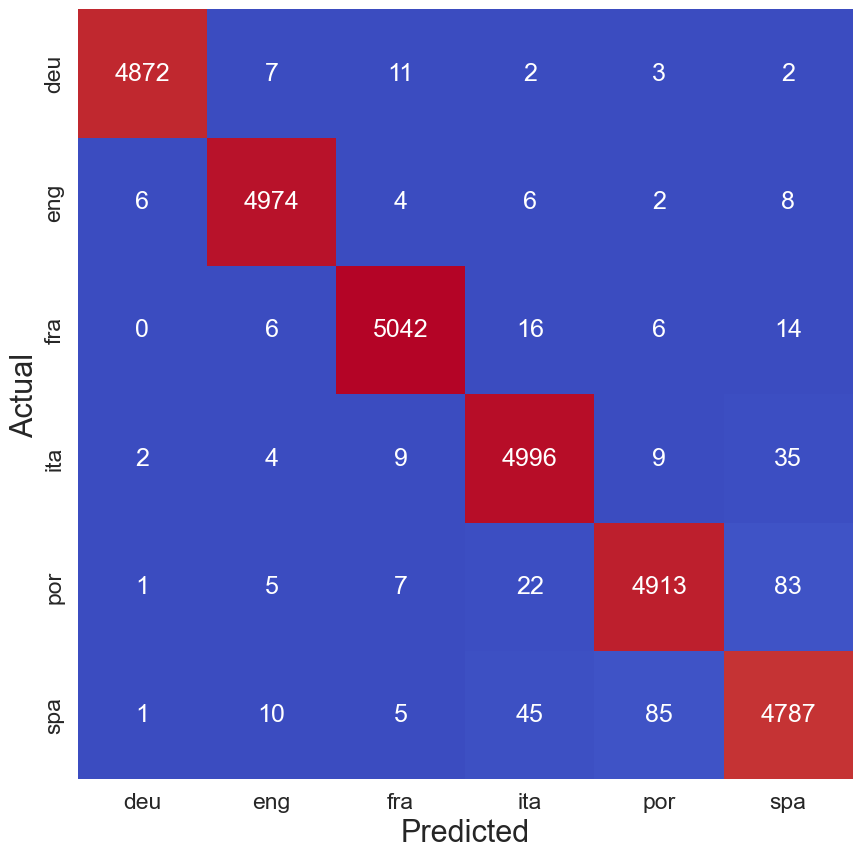

In [35]:
plt.figure(figsize=(10, 10), facecolor="w", edgecolor="k")
sns.set(font_scale=1.5)
sns.heatmap(conf_matrix_df, cmap="coolwarm", annot=True, fmt=".5g", cbar=False)
plt.xlabel("Predicted", fontsize=22)
plt.ylabel("Actual", fontsize=22)

## Export Model

In [36]:
import tensorflow as tf

tf.keras.models.save_model(
    model, "../../serverless/api/modules/detect/model", signatures=None, options=None
)

INFO:tensorflow:Assets written to: ../../serverless/api/modules/detect/model/assets


INFO:tensorflow:Assets written to: ../../serverless/api/modules/detect/model/assets
